# NLP project

## Get the Data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [38]:
import pandas as pd

In [138]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis



In [40]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [41]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [42]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

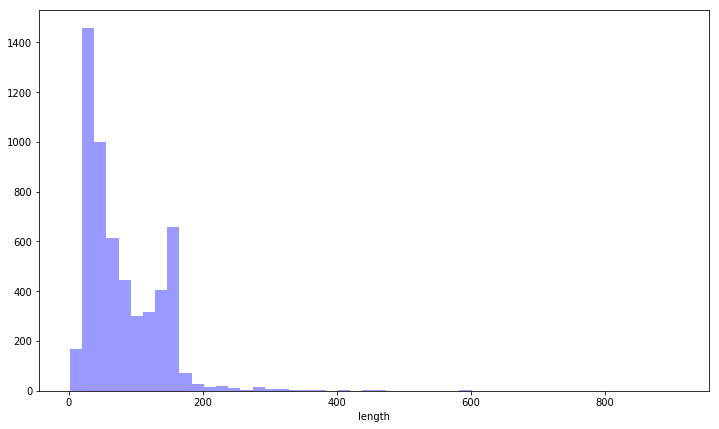

In [44]:
plt.figure(figsize=(12,7))
sns.distplot(messages.length, kde=False,color='b')
plt.show()

there is some really long message

In [45]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [46]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

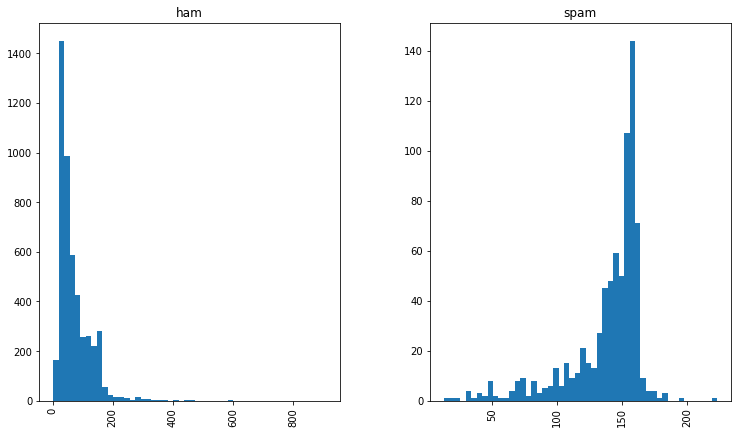

In [48]:
messages.hist(column='length', by='label', bins=50,figsize=(12,7))
plt.show()

## Text Pre-processing

In [167]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text=re.sub('[^a-z, ,]','',text)
    return text


In [168]:
df=pd.DataFrame(messages.message.apply(clean_text))

In [169]:
df.index=messages.label

In [170]:
df.head()

,message
label,
ham,go until jurong point crazy available only in ...
ham,ok lar joking wif u oni
spam,free entry in a wkly comp to win fa cup final...
ham,u dun say so early hor u c already then say
ham,nah i dont think he goes to usf he lives aroun...


## Vectorization

In [222]:
from sklearn.feature_extraction.text import CountVectorizer

In [223]:
cv=CountVectorizer(stop_words='english').fit(df.message)

In [224]:
data_bow=cv.transform(df.message)

In [225]:
#document term matrix
data_dtm=pd.DataFrame(data_bow.toarray(),columns=cv.get_feature_names())

In [226]:
data_dtm.index=messages.label

In [227]:
data_dtm.shape

(5572, 7999)

In [228]:
data_dtm=data_dtm.reset_index()

In [229]:
X=data_dtm.drop('label',axis=1)
y=data_dtm.label

## Model
Multinomial NB

In [230]:
from sklearn.model_selection import train_test_split

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [232]:
from sklearn.naive_bayes import MultinomialNB

In [233]:
mn=MultinomialNB()

In [234]:
mn.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [235]:
predicted=mn.predict(X_test)

In [236]:
mn.score(X_test,y_test)

0.9659192825112107

## Pickling

In [237]:
import pickle

In [238]:
model=pickle.dump(mn,open('model.pkl','wb'))

In [245]:
pickle.dump(cv,open('vector.pkl','wb'))

In [207]:
inp=X_test.iloc[1,:].values

In [211]:
mn.predict(inp.reshape(1,7999))

array(['ham'], dtype='<U4')

## Flask App

In [ ]:
import numpy as np
import pandas as pd
from flask import Flask, request,render_template
import pickle
import re
import string
import pandas as pd
import numpy as np

app= Flask(__name__)
model= pickle.load(open('model.pkl','rb'))
cv= pickle.load(open('vector.pkl','rb'))

@app.route('/')
def home():
    return render_template('main.html')

@app.route('/predict', methods=['POST'])
def predict():
    message=request.form['message']
    text=message
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[''""...]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[^a-z, ,]','',text)
    ddd=pd.DataFrame(index=range(0,1))
    ddd['Message']=text
    mess_bow=cv.transform(ddd.Message[0:1])
    message_co= mess_bow.toarray()
    input_variables= message_co
    final_features = input_variables
    prediction = model.predict(final_features)
    return render_template('main.html',result=prediction)

if __name__ == "__main__":
    app.run(debug=True)
    app.config['TEMPLATES_AUTO_RELOAD'] = True
